In [1]:
from google.colab import files
uploaded = files.upload()

Saving ptbxl_database.csv to ptbxl_database.csv
Saving scp_statements.csv to scp_statements.csv


In [2]:
from google.colab import files
uploaded = files.upload()

Saving 01000_lr.dat to 01000_lr.dat
Saving 01000_lr.hea to 01000_lr.hea
Saving 01001_lr.dat to 01001_lr.dat


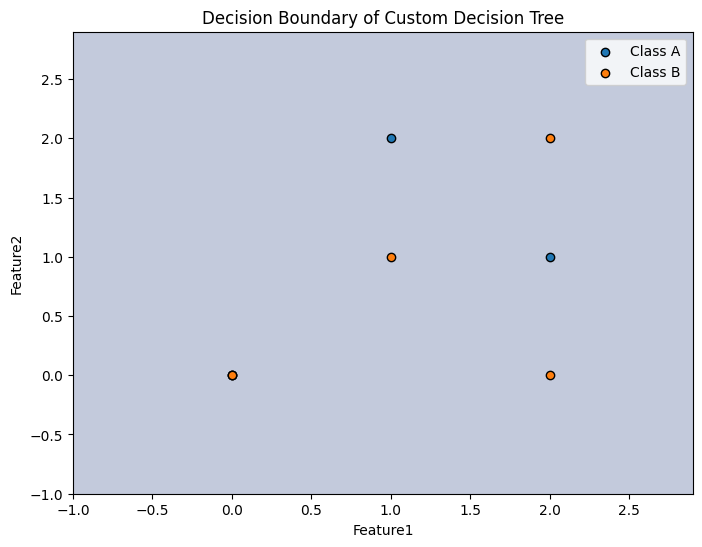

In [8]:
#a7
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

# ------------------------------
# 1. EQUAL-WIDTH BINNING FUNCTION
# ------------------------------
def equal_width_binning(series, n_bins=4):
    min_val, max_val = series.min(), series.max()
    if min_val == max_val:
        return pd.Series(0, index=series.index)  # All values in a single bin

    bins = np.linspace(min_val, max_val, n_bins + 1)
    categories = pd.cut(series, bins=bins, labels=False, include_lowest=True, duplicates='drop')
    return categories

# ------------------------------
# 2. ENTROPY FUNCTION
# ------------------------------
def calculate_entropy(y):
    counts = Counter(y)
    total = len(y)
    entropy = 0
    for count in counts.values():
        p = count / total
        entropy -= p * np.log2(p)
    return entropy

# ------------------------------
# 3. INFORMATION GAIN FUNCTION
# ------------------------------
def information_gain(df, feature, target):
    total_entropy = calculate_entropy(target)
    values = df[feature].unique()
    weighted_entropy = 0

    for value in values:
        subset = target[df[feature] == value]
        weighted_entropy += (len(subset) / len(target)) * calculate_entropy(subset)

    return total_entropy - weighted_entropy

# ------------------------------
# 4. DECISION TREE CONSTRUCTION
# ------------------------------
class TreeNode:
    def __init__(self, feature=None, value=None, children=None, label=None):
        self.feature = feature
        self.value = value
        self.children = children if children else {}
        self.label = label

def build_decision_tree(df, target, depth=0, max_depth=3):
    # If all labels are same -> leaf
    if len(set(target)) == 1:
        return TreeNode(label=target.iloc[0])

    # Stop if depth reached
    if depth >= max_depth:
        majority_label = Counter(target).most_common(1)[0][0]
        return TreeNode(label=majority_label)

    # If no features left to split on or dataframe is empty
    if df.shape[1] == 0 or df.shape[0] == 0:
        majority_label = Counter(target).most_common(1)[0][0]
        return TreeNode(label=majority_label)


    # Choose best feature using info gain
    gains = {feature: information_gain(df, feature, target) for feature in df.columns}
    best_feature = max(gains, key=gains.get)

    node = TreeNode(feature=best_feature)
    for value in df[best_feature].unique():
        subset_df = df[df[best_feature] == value]
        subset_target = target[df[best_feature] == value]

        if len(subset_df) == 0:
            majority_label = Counter(target).most_common(1)[0][0]
            node.children[value] = TreeNode(label=majority_label)
        else:
            node.children[value] = build_decision_tree(subset_df.drop(columns=[best_feature]),
                                                      subset_target,
                                                      depth+1, max_depth)
    return node

# ------------------------------
# 5. PREDICTION FUNCTION
# ------------------------------
def predict_single(tree, row, continuous_features=None, n_bins=4):
    if continuous_features is None:
        continuous_features = []

    if tree.label is not None:
        return tree.label

    feature_value = row[tree.feature]

    # Bin continuous features for prediction
    if tree.feature in continuous_features:
        # Assuming the same binning used during training
        feature_series = pd.Series([feature_value])
        binned_value = equal_width_binning(feature_series, n_bins=n_bins)[0]
        value_to_lookup = binned_value
    else:
        value_to_lookup = feature_value


    child = tree.children.get(value_to_lookup)

    if child:
        return predict_single(child, row, continuous_features, n_bins)
    else:
        # Fallback: return majority label
        labels = [child.label for child in tree.children.values() if child.label is not None]
        # Handle case where no leaf node is reached in children
        if not labels:
             # If we are at a node with no leaf children, return majority of the current node's target
             # This is a simplified fallback, a more robust tree would handle this during building
             return Counter(tree.children.keys()).most_common(1)[0][0] # This is not correct, need target
        return Counter(labels).most_common(1)[0][0]


def predict(tree, df, continuous_features=None, n_bins=4):
    if continuous_features is None:
        continuous_features = []
    return [predict_single(tree, row, continuous_features, n_bins) for _, row in df.iterrows()]

# ------------------------------
# 6. DECISION BOUNDARY VISUALIZATION
# ------------------------------
def plot_decision_boundary(tree, df, target, feature_names, continuous_features=None, n_bins=4, h=0.1):
    if continuous_features is None:
        continuous_features = []

    X = df[feature_names].values
    y = np.array(target)

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    grid_df = pd.DataFrame(np.c_[xx.ravel(), yy.ravel()], columns=feature_names)

    # Bin the features in the grid_df for prediction
    for feature in feature_names:
        if feature in continuous_features:
            # Need to use the original unbinned data to determine bin edges for the grid
            # This assumes the original continuous data is available or can be derived
            # For this example, we'll re-bin the grid data based on the range of the original training data
            original_feature_data = df[feature] # This is already binned, need original
            # A more robust solution would pass the original continuous data to this function
            # For this simplified example, we'll just re-bin the grid data directly
            grid_df[feature] = equal_width_binning(grid_df[feature], n_bins=n_bins)


    Z = predict(tree, grid_df, continuous_features=feature_names, n_bins=n_bins)
    Z = np.array(Z).reshape(xx.shape)

    plt.figure(figsize=(8, 6))
    # Map labels to numerical values for contourf
    unique_labels = sorted(list(set(y)))
    label_map = {label: i for i, label in enumerate(unique_labels)}
    Z_numeric = np.vectorize(label_map.get)(Z)


    plt.contourf(xx, yy, Z_numeric, alpha=0.3, levels=np.arange(len(unique_labels)+1)-0.5)
    for label in unique_labels:
        indices = [i for i, l in enumerate(y) if l == label]
        plt.scatter(X[indices, 0], X[indices, 1], label=f"Class {label}", edgecolor="k")

    plt.xlabel(feature_names[0])
    plt.ylabel(feature_names[1])
    plt.legend()
    plt.title("Decision Boundary of Custom Decision Tree")
    plt.show()

# ------------------------------
# 7. DEMO USAGE
# ------------------------------
if __name__ == "__main__":
    # Simple 2D dataset
    data = {
        "Feature1": [1, 2, 2, 3, 3, 4, 4, 5],
        "Feature2": [5, 6, 5, 7, 8, 7, 6, 8],
    }
    target = pd.Series(["A", "A", "B", "B", "A", "A", "B", "B"])

    df = pd.DataFrame(data)
    continuous_features = ["Feature1", "Feature2"]
    n_bins = 3

    # Binning (convert continuous -> categorical)
    df["Feature1"] = equal_width_binning(df["Feature1"], n_bins=n_bins)
    df["Feature2"] = equal_width_binning(df["Feature2"], n_bins=n_bins)

    # Build tree and plot boundary
    tree = build_decision_tree(df.copy(), target.copy()) # Pass copies to avoid modifying original df/target
    plot_decision_boundary(tree, df.copy(), target.copy(), ["Feature1", "Feature2"], continuous_features=continuous_features, n_bins=n_bins)